In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
from torch.utils.data import WeightedRandomSampler, DataLoader, Dataset

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import time

import seaborn as sns
from scipy import ndimage

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('running on:', device)

running on: cuda:0


In [3]:
SOURCE_IMG_SIZE = 48
IMG_SIZE = 96

CLASSES = ['neutral', 'happy', 'surprised', 'sad', 'angry'] #, 'disgusted', 'afraid'
NUM_CLASSES = len(CLASSES)

In [4]:
df_fer = pd.read_csv('data/fer2013.csv').iloc[:, 1:]
df_ferplus = pd.read_csv('data/ferplus2013.csv').iloc[:, [2, 3, 4, 5, 6]] # Change this if size of classes is changed
df = df_fer.join(df_ferplus)
# df.head(15)

df['emotion'] = df.iloc[:, 2:].idxmax(axis=1).tolist()
df = df.replace(dict(zip(pd.Series(CLASSES),pd.Series(CLASSES).index)))
# df.head(15)

print('number of images:', df.shape[0])
df = df[(df.iloc[:, 2:-1].max(axis=1) > 5)]
print('after removing images with unknown/unsure classification:', df.shape[0])
# df.head(15)

df = df.iloc[:, [0, 1, -1]]
# df.head(15)

number of images: 35887
after removing images with unknown/unsure classification: 26811


In [5]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

images_np = np.array(df['pixels'])
label_np = np.array(df['emotion'])

images = []
images_raw = []
labels = []

for i in range(df.shape[0]):
    b = bytes(int(p) for p in images_np[i].split())
    img = Image.frombuffer('L', (SOURCE_IMG_SIZE, SOURCE_IMG_SIZE), b)
    images.append(transform(img))
    images_raw.append(img)
    labels.append(label_np[i])

In [6]:
kirsch_compass_masks = [
    np.array([[-3,-3,5],[-3,0,5],[-3,-3,5]]),   # north
    np.array([[-3,-3,-3],[-3,0,5],[-3,5,5]]),   # north-east
    np.array([[-3,-3,-3],[-3,0,-3],[5,5,5]]),   # east
    np.array([[-3,-3,-3],[5,0,-3],[5,5,-3]]),   # south-east
    # np.array([[5,-3,-3],[5,0,-3],[5,-3,-3]]),   # south
    # np.array([[5,5,-3],[5,0,-3],[-3,-3,-3]]),   # south-west 
    # np.array([[5,5,5],[-3,0,-3],[-3,-3,-3]]),   # west
    # np.array([[-3,5,5],[-3,0,5],[-3,-3,-3]]),   # north-west
]

In [7]:
images_filtered = []

transform = transforms.Compose([
    transforms.ToTensor()
])

for i in range(len(images)):
    img = images[i].squeeze(0)

    filtered = np.zeros_like(img)
    for cm in kirsch_compass_masks:
        k = ndimage.convolve(img, cm, mode='nearest', cval=0.0)
        filtered = np.add(filtered, k)

    filtered = transform(filtered)
    images_filtered.append(filtered)

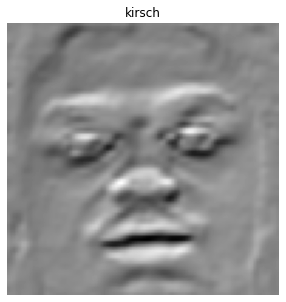

In [8]:
img = images_filtered[random.randint(0, len(images_filtered)-1)]

plt.figure(figsize=(5,5))
plt.title('kirsch')
plt.axis('off')
plt.imshow(img.permute(1,2,0), cmap='gray')

In [9]:
label_counts = [0]*NUM_CLASSES

for i in range(len(labels)):
    label_counts[labels[i]] += 1

print('\033[4m{: <15} {: >10}\033[0m'.format('class', '#images'))
for i in range(NUM_CLASSES):
    print('{: <15} {: >10}'.format(CLASSES[i], label_counts[i]))

class              #images
neutral               9494
happy                 8802
surprised             3461
sad                   2958
angry                 2096


In [10]:
train_split_pct = 0.8
train_len = int(len(labels) * train_split_pct)

train_images = images_filtered[:train_len]
train_labels = labels[:train_len]
test_images = images_filtered[train_len:]
test_labels = labels[train_len:]

print(f'train length: {len(train_labels)} ({len(train_labels)*100/len(labels):.1f}%)')
print(f'test length: {len(test_labels)} ({len(test_labels)*100/len(labels):.1f}%)')

train length: 21448 (80.0%)
test length: 5363 (20.0%)


In [11]:
BATCH_SIZE = 32


class CustomDataset(Dataset):
    
    def __init__(self, images, labels):      
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


train_dataset = CustomDataset(train_images, train_labels)
test_dataset = CustomDataset(test_images, test_labels)


def get_loader(dataset):
    print('get_loader():')

    label_counts = [0]*NUM_CLASSES
    for i in range(len(dataset.labels)):
        label_counts[dataset.labels[i]] += 1

    class_weights = pow(np.array(label_counts) / sum(label_counts), -1)
    print('  class weights:', class_weights.round(3), '\n')

    sample_weights = [0]*len(dataset)
    for idx, (image, label) in enumerate(dataset):
        sample_weights[idx] = class_weights[label]

    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    return DataLoader(dataset, BATCH_SIZE, sampler=sampler, shuffle=False)


train_loader = get_loader(train_dataset)
test_loader = get_loader(test_dataset)

get_loader():
  class weights: [ 2.848  3.015  7.771  8.963 12.991] 

get_loader():
  class weights: [ 2.732  3.175  7.65   9.492 12.052] 



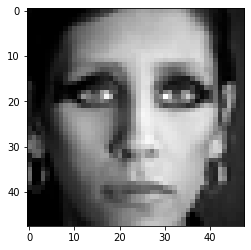

In [30]:
plt.imshow(images_raw[1], cmap="gray")

In [12]:
# Batch size during training, remember to change the global one as well
batch_size = BATCH_SIZE

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.01

In [13]:
class_names = CLASSES
print(class_names)

def visualize_expression_model(model, num_images=4):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                plt.imshow(inputs.cpu().data[j].permute(1, 2, 0), cmap="gray")

                if images_so_far == num_images:
                    return

['neutral', 'happy', 'surprised', 'sad', 'angry']


In [14]:
def train_expression_model(model, data, criterion, optimizer):
    since = time.time()
    best_acc = 0.0
    model.train()   # Set model to train mode
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in data:
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # zero the parameter gradients, and use backpropagatation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    print('train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

In [15]:
def test_expression_model(model, data, criterion):
    since = time.time()
    best_acc = 0.0
    model.eval()   # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in data:
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects.double() / len(test_dataset)

    print('test Loss: {:.4f} Acc: {:.4f}'.format(
        epoch_loss, epoch_acc))

In [16]:
from alexnet_model import Facial_Expression_Network_AlexNet

In [17]:
expression_model = Facial_Expression_Network_AlexNet().to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(expression_model.parameters(), lr=lr, momentum = 0.8)
#optimizer = torch.optim.Adam(expression_model.parameters(), lr=lr)

# Decay LR by a factor of 0.1 every 1 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.0001)

In [18]:
for epoch in range(1, (num_epochs+1)):
    print('Epoch {}/{}'.format(epoch, num_epochs))
    print()
    train_expression_model(expression_model, train_loader, loss_fn, optimizer)
    test_expression_model(expression_model, test_loader, loss_fn)
    scheduler.step

Epoch 1/50

torch.Size([32, 1, 96, 96])


AttributeError: 'int' object has no attribute 'double'

In [ ]:
#torch.save(expression_model.state_dict(), "data/face_expression_model.pt")